# exercise 5: pdb Ramachandran Plot (phi-psi map)

In [5]:
import os
import numpy as np
import gzip
import matplotlib.pyplot as plt

In [6]:
data_dir = 'pisces/pdb'
list_file = data_dir + '/list.txt'
pdb_list = [x.strip().split() for x in open(list_file)]

In [7]:
main_atom_list = [' N  ', ' CA ', ' C  ', ' O  ']
Res31 = {'ALA': 'A', 'CYS': 'C', 'ASP': 'D', 'GLU': 'E', 'PHE': 'F',
         'GLY': 'G', 'HIS': 'H', 'ILE': 'I', 'LYS': 'K', 'LEU': 'L',
         'MET': 'M', 'ASN': 'N', 'PRO': 'P', 'GLN': 'Q', 'ARG': 'R',
         'SER': 'S', 'THR': 'T', 'VAL': 'V', 'TRP': 'W', 'TYR': 'Y', }
res_list = Res31.keys()

In [8]:
def read_pdb(pdb_file):
    fp = gzip.open(pdb_file)
    lines = fp.readlines()
    fp.close()
    chain_dict = dict()
    atom_coor_dict = dict()

    check_m = False
    modres_dict = dict()
    for line_b in lines:
        line = line_b.decode('ascii')
        if line[0:10] == 'REMARK 465':
            if line[15:27] == 'RES C SSSEQI':
                check_m = True
                continue
            if check_m:
                res_name3 = line[15:18]
                res_inser = line[22:27]
                chain_id = line[19]
                if chain_id not in chain_dict:
                    chain_dict[chain_id] = dict()
                    atom_coor_dict[chain_id] = dict()
                chain_dict[chain_id][res_inser] = res_name3
                atom_coor_dict[chain_id][res_inser] = dict()

        elif line[0:6] == 'MODRES':
            res_name3_mod = line[12:15]
            res_name3 = line[24:27]
            if res_name3_mod not in modres_dict and res_name3 in Res31:
                modres_dict[res_name3_mod] = res_name3

        elif line[0:6] == 'ATOM  ':
            chain_id = line[21]
            res_name3 = line[17:20]
            res_inser = line[22:27]

            alt_loc = line[16]
            if alt_loc != ' ' and alt_loc != 'A':
                continue

            if chain_id not in chain_dict:
                chain_dict[chain_id] = dict()
                atom_coor_dict[chain_id] = dict()
            if res_name3 not in Res31:
                continue
            if res_inser not in chain_dict[chain_id]:
                chain_dict[chain_id][res_inser] = res_name3
                atom_coor_dict[chain_id][res_inser] = dict()

            atom_name = line[12:16]

            if atom_name in main_atom_list:
                coor = (line[30:38], line[38:46], line[46:54])
                coor = np.array(coor, dtype=np.float64)
                atom_coor_dict[chain_id][res_inser][atom_name] = coor

        elif line[0:6] == 'HETATM':
            chain_id = line[21]
            res_name3 = line[17:20]
            res_inser = line[22:27]
            alt_loc = line[16]
            if alt_loc != ' ' and alt_loc != 'A':
                continue

            if chain_id not in chain_dict:
                chain_dict[chain_id] = dict()
                atom_coor_dict[chain_id] = dict()
            if res_name3 not in modres_dict:
                continue

            if res_inser not in chain_dict[chain_id]:
                chain_dict[chain_id][res_inser] = res_name3
                atom_coor_dict[chain_id][res_inser] = dict()

            atom_name = line[12:16]
            if atom_name in main_atom_list:
                coor = (line[30:38], line[38:46], line[46:54])
                coor = np.array(coor, dtype=np.float64)
                atom_coor_dict[chain_id][res_inser][atom_name] = coor

    return chain_dict, atom_coor_dict, modres_dict

In [9]:
def cal_angle(pos_1, pos_2, pos_3):
    va = pos_1 - pos_2
    vb = pos_3 - pos_2
    vc = va + vb
    a2 = va.dot(va)
    b2 = vb.dot(vb)
    a = np.sqrt(a2)
    b = np.sqrt(b2)
    c2 = vc.dot(vc)
    cos_angle = (c2 - a2 - b2) / (2*a*b)
    angle = np.arccos(cos_angle)
    return 180 * angle / np.pi

In [10]:
def cal_normal_vector(pos_1, pos_2, pos_3):
    va = pos_2 - pos_1
    vb = pos_3 - pos_2
    vp = np.cross(va, vb)
    p = np.linalg.norm(vp)
    return vp/p

In [11]:
def cal_torsional_angle(pos_1, pos_2, pos_3, pos_4):
    na = cal_normal_vector(pos_1, pos_2, pos_3)
    nb = cal_normal_vector(pos_2, pos_3, pos_4)
    vc = nb+na
    a2 = na.dot(na)
    b2 = nb.dot(nb)
    a = np.sqrt(a2)
    b = np.sqrt(b2)
    c2 = vc.dot(vc)
    cos_angle = (c2 - a2 - b2) / (2*a*b)

    vd = np.cross(na, nb)
    nd = vd/np.linalg.norm(vd)
    v32 = pos_3-pos_2
    n32 = v32/np.linalg.norm(v32)
    z = n32.dot(nd)
    angle = np.arccos(cos_angle)
    angle2 = z*180 * angle / np.pi

    return angle2

In [12]:
def cal_single(chain_dict, atom_coor_dict, modres_dict, chain_id, res_angle_dict):
    keys = sorted(chain_dict[chain_id].keys())
    num_keys = len(keys)
    for i in range(num_keys):
        key = keys[i]
        res_name = chain_dict[chain_id][key]
        if res_name in modres_dict:
            res_name = modres_dict[res_name]

        res_dict = atom_coor_dict[chain_id][key]
        if ' N  ' in res_dict:
            pos_n = res_dict[' N  ']
        else:
            continue
        if ' CA ' in res_dict:
            pos_ca = res_dict[' CA ']
        else:
            continue
        if ' C  ' in res_dict:
            pos_c = res_dict[' C  ']
        else:
            continue

        angle = cal_angle(pos_n, pos_ca, pos_c)
        if i != 0:
            key_m = keys[i-1]
            res_m_dict = atom_coor_dict[chain_id][key_m]
            if ' C  ' in res_m_dict:
                pos_cm = res_m_dict[' C  ']
                phi = cal_torsional_angle(pos_cm, pos_n, pos_ca, pos_c)
            else:
                phi = None
        else:
            phi = None
        if i != num_keys-1:
            key_p = keys[i+1]
            res_p_dict = atom_coor_dict[chain_id][key_p]
            if ' N  ' in res_p_dict:
                pos_np = res_p_dict[' N  ']
                psi = cal_torsional_angle(pos_n, pos_ca, pos_c, pos_np)

            else:
                psi = None
        else:
            psi = None

        if angle is not None and phi is not None and psi is not None:
            res_angle_dict[res_name] += [[angle, phi, psi]]

In [13]:
res_angle_dict = dict()
for res_name in res_list:
    res_angle_dict[res_name] = list()
    
num_pdb = len(pdb_list)
for i in range(0, num_pdb):
    pdb_id = pdb_list[i][0]
    chain_id = pdb_list[i][1]
    # print(pdb_id)
    pdb_file = '%s/%s/%s.pdb.gz' % (data_dir, pdb_id[0], pdb_id)
    if not os.path.exists(pdb_file):
        print('No such file', pdb_file)
        continue
    chain_dict, atom_coor_dict, modres_dict = read_pdb(pdb_file)
    cal_single(chain_dict, atom_coor_dict, modres_dict, chain_id, res_angle_dict)

No such file pisces/pdb/4/4V4M.pdb.gz
No such file pisces/pdb/6/6TAK.pdb.gz
No such file pisces/pdb/6/6TN5.pdb.gz
No such file pisces/pdb/6/6TWO.pdb.gz
No such file pisces/pdb/6/6XTD.pdb.gz
No such file pisces/pdb/6/6XTD.pdb.gz
No such file pisces/pdb/6/6XY7.pdb.gz
No such file pisces/pdb/7/7AF2.pdb.gz
No such file pisces/pdb/7/7AVC.pdb.gz
No such file pisces/pdb/7/7B6A.pdb.gz
No such file pisces/pdb/7/7M1A.pdb.gz
No such file pisces/pdb/7/7NQG.pdb.gz
No such file pisces/pdb/7/7NZD.pdb.gz
No such file pisces/pdb/7/7OLW.pdb.gz
No such file pisces/pdb/7/7OMV.pdb.gz
No such file pisces/pdb/7/7OS5.pdb.gz
No such file pisces/pdb/7/7OST.pdb.gz
No such file pisces/pdb/7/7P24.pdb.gz
No such file pisces/pdb/7/7P5R.pdb.gz
No such file pisces/pdb/7/7PJ4.pdb.gz
No such file pisces/pdb/7/7Q4T.pdb.gz
No such file pisces/pdb/7/7QYM.pdb.gz
No such file pisces/pdb/7/7QYM.pdb.gz


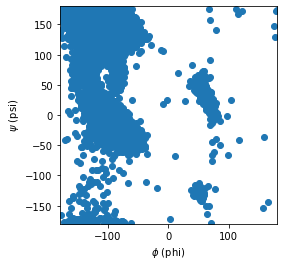

In [14]:
rama = np.array(res_angle_dict['ALA'])
fig1, ax = plt.subplots()
ax.set_box_aspect(1)
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.xlabel('$\phi$ (phi)')
plt.ylabel('$\psi$ (psi)')
plt.scatter(rama[:, 1], rama[:, 2])

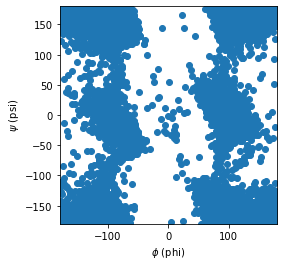

In [15]:
rama = np.array(res_angle_dict['GLY'])
fig1, ax = plt.subplots()
ax.set_box_aspect(1)
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.xlabel('$\phi$ (phi)')
plt.ylabel('$\psi$ (psi)')
plt.scatter(rama[:, 1], rama[:, 2])

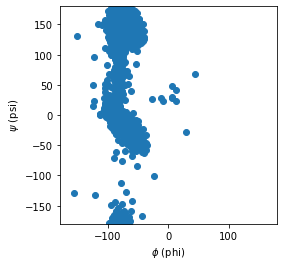

In [16]:
rama = np.array(res_angle_dict['PRO'])
fig1, ax = plt.subplots()
ax.set_box_aspect(1)
plt.xlim(-180, 180)
plt.ylim(-180, 180)
plt.xlabel('$\phi$ (phi)')
plt.ylabel('$\psi$ (psi)')
plt.scatter(rama[:, 1], rama[:, 2])